# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.

In [217]:
# Import standard libraries
import numpy as np
import pandas as pd

# Import visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Import preprocessing libraries
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.impute import SimpleImputer


# Import model selection libraries
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV

# Import clustering and decomposition libraries
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# Import ensemble methods
from sklearn.ensemble import AdaBoostRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
import xgboost

# Import evaluation metrics
from sklearn.metrics import roc_auc_score, fbeta_score, accuracy_score, precision_score, recall_score

# Import additional libraries
from scipy import stats
from time import time

# Enable inline plotting for visualizations
%matplotlib inline

# Optional: Import additional useful libraries
import warnings
warnings.filterwarnings('ignore')



## Part 0: Get to Know the Data

There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. Use the information from the first two files to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("AZDIAS"), then use your analysis to make predictions on the other two files ("MAILOUT"), predicting which recipients are most likely to become a customer for the mail-order company.

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed; it is against that withheld column that your final predictions will be assessed in the Kaggle competition.

Otherwise, all of the remaining columns are the same between the three data files. For more information about the columns depicted in the files, you can refer to two Excel spreadsheets provided in the workspace. [One of them](./DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category. [The other](./DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order.

In the below cell, we've provided some initial code to load in the first two datasets. Note for all of the `.csv` data files in this project that they're semicolon (`;`) delimited, so an additional argument in the [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call has been included to read in the data properly. Also, considering the size of the datasets, it may take some time for them to load completely.

You'll notice when the data is loaded in that a warning message will immediately pop up. Before you really start digging into the modeling and analysis, you're going to need to perform some cleaning. Take some time to browse the structure of the data and look over the informational spreadsheets to understand the data values. Make some decisions on which features to keep, which features to drop, and if any revisions need to be made on data formats. It'll be a good idea to create a function with pre-processing steps, since you'll need to clean all of the datasets before you work with them.

In [2]:
# load in the data
azdias = pd.read_csv('data/Udacity_AZDIAS_052018.csv', sep=';')
customers = pd.read_csv('data/Udacity_CUSTOMERS_052018.csv', sep=';')

In [3]:
# shape of the general population data
print('Number of rows: ', azdias.shape[0])
print('Number of columns: ', azdias.shape[1])

azdias.head()

Number of rows:  891221
Number of columns:  366


,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,910215,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,1,2
1,910220,-1,9.0,0.0,NaN,NaN,NaN,NaN,21.0,11.0,...,4.0,8.0,11.0,10.0,3.0,9.0,4.0,5,2,1
2,910225,-1,9.0,17.0,NaN,NaN,NaN,NaN,17.0,10.0,...,2.0,9.0,9.0,6.0,3.0,9.0,2.0,5,2,3
3,910226,2,1.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,...,0.0,7.0,10.0,11.0,NaN,9.0,7.0,3,2,4
4,910241,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,3.0,...,2.0,3.0,5.0,4.0,2.0,9.0,3.0,4,1,3


In [4]:
# shape of customers population data
print('Number of rows: ', customers.shape[0])
print('Number of columns: ', customers.shape[1])

customers.head()

Number of rows:  191652
Number of columns:  369


,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,PRODUCT_GROUP,CUSTOMER_GROUP,ONLINE_PURCHASE,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,9626,2,1.0,10.0,NaN,NaN,NaN,NaN,10.0,1.0,...,2.0,6.0,9.0,7.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,1,4
1,9628,-1,9.0,11.0,NaN,NaN,NaN,NaN,NaN,NaN,...,3.0,0.0,9.0,NaN,3,FOOD,SINGLE_BUYER,0,1,4
2,143872,-1,1.0,6.0,NaN,NaN,NaN,NaN,0.0,1.0,...,11.0,6.0,9.0,2.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,2,4
3,143873,1,1.0,8.0,NaN,NaN,NaN,NaN,8.0,0.0,...,2.0,NaN,9.0,7.0,1,COSMETIC,MULTI_BUYER,0,1,4
4,143874,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,7.0,...,4.0,2.0,9.0,3.0,1,FOOD,MULTI_BUYER,0,1,3


# 1 Exploratory Data Analysis

In [5]:
# Calculate the total number of missing values and their percentage for each column in the azdias DataFrame
azdias_missing_values = azdias.isnull().sum()  # Total missing values for each feature
azdias_missing_values_percent = azdias_missing_values / len(azdias) * 100  # Percentage of missing values

print("Total missing values for each feature in azdias DataFrame:\n")
print(azdias_missing_values)

# Print a separator for better readability
print("\n" + "-"*50 + "\n")

print("Percentage of missing values for each feature in azdias DataFrame:\n")
print(azdias_missing_values_percent)

Total missing values for each feature in azdias DataFrame:

LNR                          0
AGER_TYP                     0
AKT_DAT_KL               73499
ALTER_HH                 73499
ALTER_KIND1             810163
                         ...  
WOHNDAUER_2008           73499
WOHNLAGE                 93148
ZABEOTYP                     0
ANREDE_KZ                    0
ALTERSKATEGORIE_GROB         0
Length: 366, dtype: int64

--------------------------------------------------

Percentage of missing values for each feature in azdias DataFrame:

LNR                      0.000000
AGER_TYP                 0.000000
AKT_DAT_KL               8.247000
ALTER_HH                 8.247000
ALTER_KIND1             90.904837
                          ...    
WOHNDAUER_2008           8.247000
WOHNLAGE                10.451729
ZABEOTYP                 0.000000
ANREDE_KZ                0.000000
ALTERSKATEGORIE_GROB     0.000000
Length: 366, dtype: float64


In [6]:
# This will summarize numerical features, providing insight into the dataset
azdias.describe()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
count,8.912210e+05,891221.000000,817722.000000,817722.000000,81058.000000,29499.000000,6170.000000,1205.000000,628274.000000,798073.000000,...,770025.000000,815304.000000,815304.000000,815304.000000,783619.000000,817722.000000,798073.000000,891221.000000,891221.000000,891221.000000
mean,6.372630e+05,-0.358435,4.421928,10.864126,11.745392,13.402658,14.476013,15.089627,13.700717,8.287263,...,2.417322,6.001214,7.532130,5.945972,3.933406,7.908791,4.052836,3.362438,1.522098,2.777398
std,2.572735e+05,1.198724,3.638805,7.639683,4.097660,3.243300,2.712427,2.452932,5.079849,15.628087,...,1.166572,2.856091,3.247789,2.771464,1.964701,1.923137,1.949539,1.352704,0.499512,1.068775
min,1.916530e+05,-1.000000,1.000000,0.000000,2.000000,2.000000,4.000000,7.000000,0.000000,0.000000,...,0.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,1.000000,1.000000
25%,4.144580e+05,-1.000000,1.000000,0.000000,8.000000,11.000000,13.000000,14.000000,11.000000,1.000000,...,2.000000,3.000000,5.000000,4.000000,2.000000,8.000000,3.000000,3.000000,1.000000,2.000000
50%,6.372630e+05,-1.000000,3.000000,13.000000,12.000000,14.000000,15.000000,15.000000,14.000000,4.000000,...,2.000000,6.000000,8.000000,6.000000,4.000000,9.000000,3.000000,3.000000,2.000000,3.000000
75%,8.600680e+05,-1.000000,9.000000,17.000000,15.000000,16.000000,17.000000,17.000000,17.000000,9.000000,...,3.000000,9.000000,10.000000,8.000000,6.000000,9.000000,5.000000,4.000000,2.000000,4.000000
max,1.082873e+06,3.000000,9.000000,21.000000,18.000000,18.000000,18.000000,18.000000,25.000000,595.000000,...,4.000000,11.000000,13.000000,11.000000,6.000000,9.000000,8.000000,6.000000,2.000000,9.000000


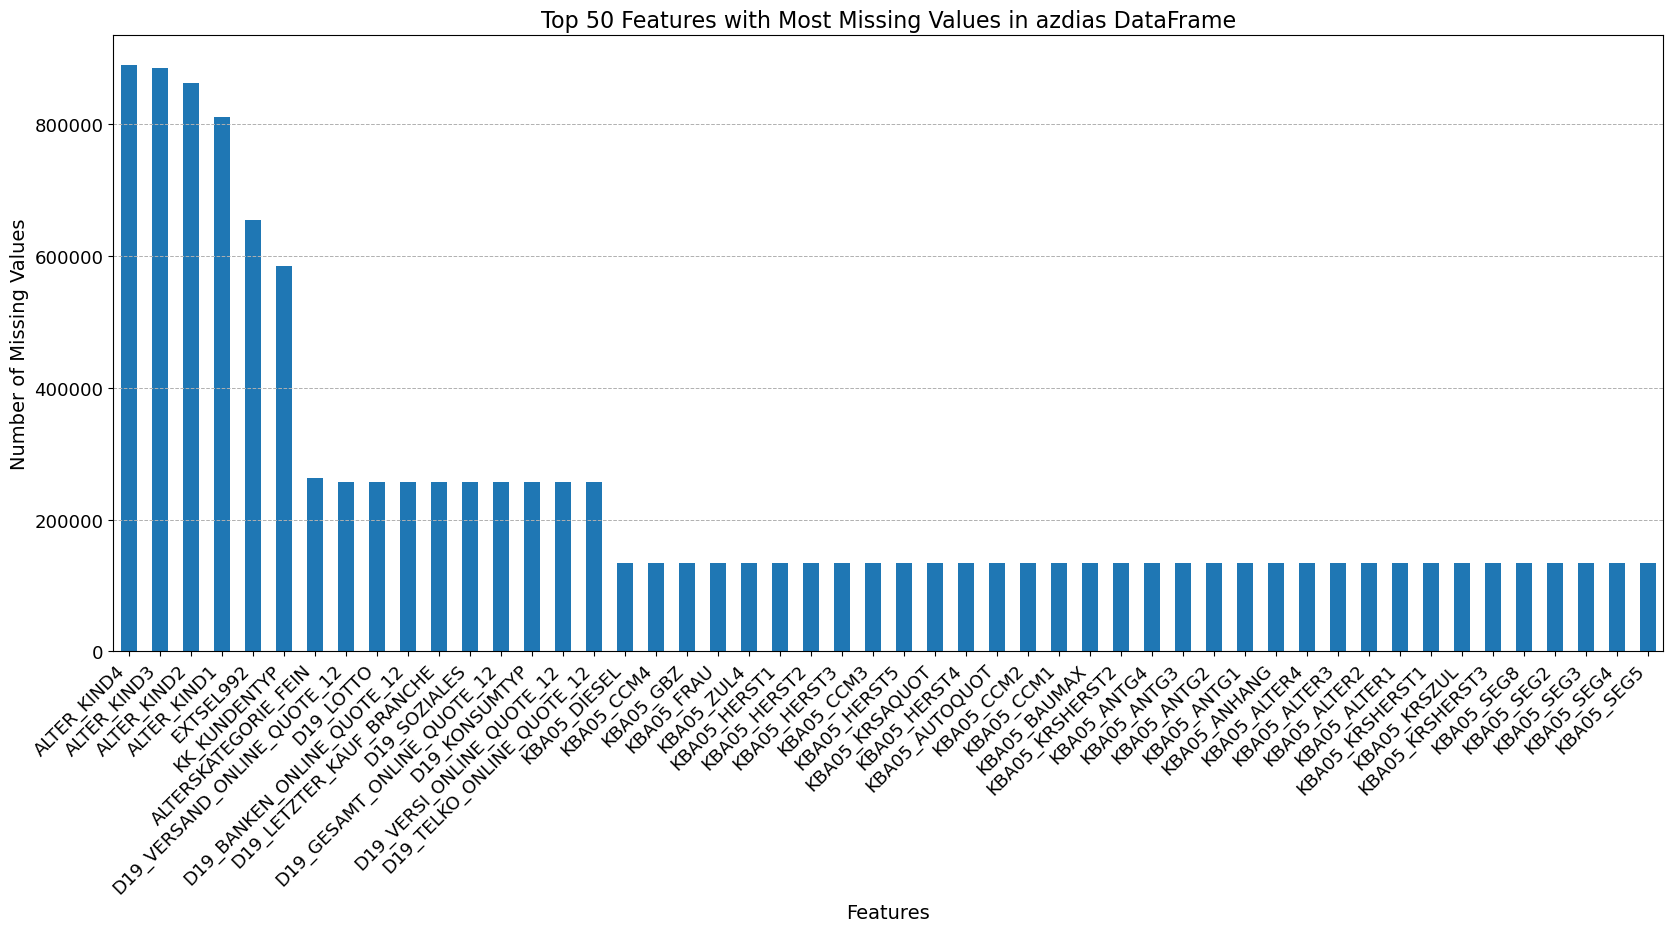

In [7]:
# Visualize the top 50 features with the most missing values in the azdias DataFrame
# Sort the missing values in descending order and select the top 50 features
top_missing_azdias = azdias_missing_values.sort_values(ascending=False)[:50]

# Plot the top 50 features with the most missing values
plt.figure(figsize=(20, 8))
top_missing_azdias.plot(kind='bar', fontsize=13)
plt.title('Top 50 Features with Most Missing Values in azdias DataFrame', fontsize=16)
plt.xlabel('Features', fontsize=14)
plt.ylabel('Number of Missing Values', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', linewidth=0.7)
plt.show()


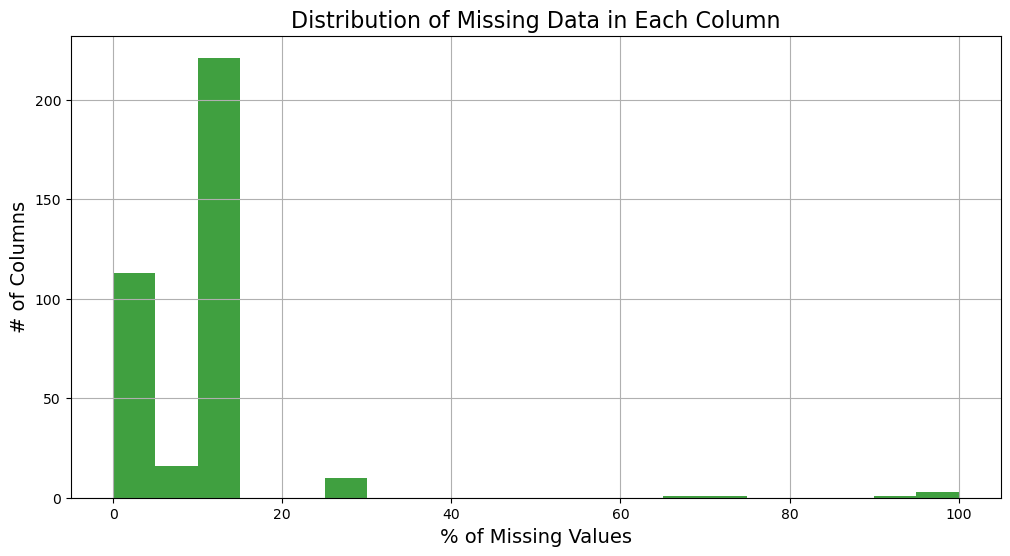

% of Missing Data in Columns:

ALTER_KIND4                  99.864792
ALTER_KIND3                  99.307691
ALTER_KIND2                  96.690047
ALTER_KIND1                  90.904837
EXTSEL992                    73.399639
                               ...    
D19_VERSAND_ANZ_24            0.000000
D19_VERSAND_DATUM             0.000000
D19_VERSAND_OFFLINE_DATUM     0.000000
D19_VERSAND_ONLINE_DATUM      0.000000
ALTERSKATEGORIE_GROB          0.000000
Length: 366, dtype: float64


In [8]:
# Visualize the distribution of missing data by percentage in the azdias DataFrame
plt.figure(figsize=(12, 6))
bins = np.linspace(0, 100, 21)  # Define bins for the histogram with better scaling

# Plot histogram of the percentage of missing values in each column
plt.hist(azdias_missing_values_percent, bins=bins, facecolor='g', alpha=0.75)
plt.xlabel('% of Missing Values', fontsize=14)
plt.ylabel('# of Columns', fontsize=14)
plt.title('Distribution of Missing Data in Each Column', fontsize=16)
plt.grid(True)

# Display the plot
plt.show()

# Print the percentage of missing data in columns, sorted in descending order
print('% of Missing Data in Columns:\n')
print(azdias_missing_values_percent.sort_values(ascending=False))


In [9]:
# Review of missing data distribution:
# From previous visualizations, we observed that the percentage of missing data in columns ranges from very low to around 17%.
# Beyond this, there is a drastic increase in the percentage of missing fields, highlighting potential outliers.

# Let's manually print the distribution of missing values to understand the extent of missing data and identify any clear outliers.

# Count the number of columns with missing values greater than specific thresholds
thresholds = [0, 10, 20, 30, 40, 60, 65, 80, 90]
missing_counts = {threshold: len(azdias_missing_values_percent[azdias_missing_values_percent > threshold]) for threshold in thresholds}

# Print the results with detailed comments
print("Distribution of Columns with Missing Values Above Specified Percentages:\n")
for threshold, count in missing_counts.items():
    print(f"Columns with >{threshold}% missing values: {count}")

# Provide additional insight into the distribution
print("\nFrom the above distribution, we can see that columns with missing values beyond certain thresholds are significantly fewer, highlighting potential outliers.\n")


Distribution of Columns with Missing Values Above Specified Percentages:

Columns with >0% missing values: 273
Columns with >10% missing values: 237
Columns with >20% missing values: 16
Columns with >30% missing values: 6
Columns with >40% missing values: 6
Columns with >60% missing values: 6
Columns with >65% missing values: 6
Columns with >80% missing values: 4
Columns with >90% missing values: 4

From the above distribution, we can see that columns with missing values beyond certain thresholds are significantly fewer, highlighting potential outliers.



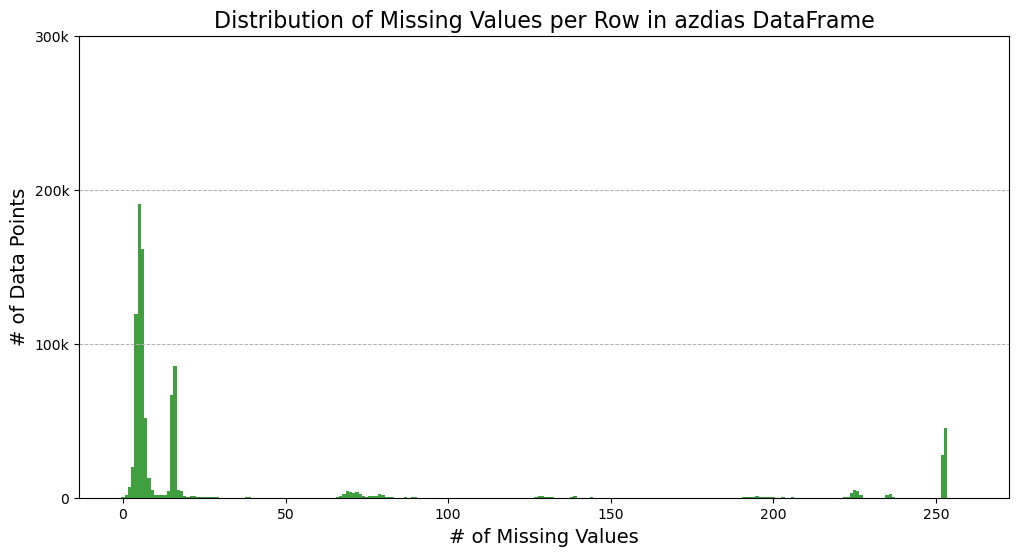

In [10]:
# Analyze the distribution of missing values at the row level in the azdias DataFrame

# Calculate the number of missing values for each row
row_missing_values = azdias.isnull().sum(axis=1)

# Set up the figure for the histogram
plt.figure(figsize=(12, 6))

# Plot histogram of the number of missing values per row
plt.hist(row_missing_values, bins=np.arange(-0.5, row_missing_values.max() + 1, 1), facecolor='g', alpha=0.75)
plt.yticks(np.arange(0, 300000 + 100000, 100000), ['0', '100k', '200k', '300k'])  # Set y-ticks with readable labels
plt.ylabel('# of Data Points', fontsize=14)
plt.xlabel('# of Missing Values', fontsize=14)
plt.title('Distribution of Missing Values per Row in azdias DataFrame', fontsize=16)
plt.grid(axis='y', linestyle='--', linewidth=0.7)

# Display the plot
plt.show()

# Additional comments
# - The histogram helps in understanding the distribution of missing values across rows.
# - The x-axis represents the number of missing values in a row.
# - The y-axis shows the number of data points (rows) with the corresponding number of missing values.


In [11]:
# Calculate the percentage of data kept for rows with a certain number of missing data points
# This will help determine an appropriate threshold for the maximum number of missing values allowed per row

# Calculate the cumulative sum of rows with up to a certain number of missing values
cumulative_data_kept = azdias.isnull().sum(axis=1).value_counts().sort_index().cumsum()

# Calculate the percentage of the total data
percentage_data_kept = cumulative_data_kept / azdias.shape[0] * 100

# Display the percentage of data kept for the first 30 cumulative sums in a more intuitive way
print("Percentage of Data Kept for Rows with Various Numbers of Missing Data Points:\n")

for num_missing, percent_kept in percentage_data_kept[:30].iteritems():
    print(f"Rows with {num_missing} or fewer missing values: {percent_kept:.0f}% of data kept")

# Additional comments:
# - This analysis shows the cumulative percentage of data retained when rows with a certain number of missing values are kept.
# - It helps in choosing a threshold for the maximum number of missing values per row to retain a significant portion of the dataset.
# - From the results, we observe that around 16% of the data is retained before the increase in retained data stagnates.


Percentage of Data Kept for Rows with Various Numbers of Missing Data Points:

Rows with 0 or fewer missing values: 0% of data kept
Rows with 1 or fewer missing values: 0% of data kept
Rows with 2 or fewer missing values: 1% of data kept
Rows with 3 or fewer missing values: 3% of data kept
Rows with 4 or fewer missing values: 17% of data kept
Rows with 5 or fewer missing values: 38% of data kept
Rows with 6 or fewer missing values: 56% of data kept
Rows with 7 or fewer missing values: 62% of data kept
Rows with 8 or fewer missing values: 63% of data kept
Rows with 9 or fewer missing values: 64% of data kept
Rows with 10 or fewer missing values: 64% of data kept
Rows with 11 or fewer missing values: 64% of data kept
Rows with 12 or fewer missing values: 65% of data kept
Rows with 13 or fewer missing values: 65% of data kept
Rows with 14 or fewer missing values: 65% of data kept
Rows with 15 or fewer missing values: 73% of data kept
Rows with 16 or fewer missing values: 82% of data kept


### Conclusion of Exploratory Data Analysis (EDA)

* The exploratory data analysis revealed crucial insights into the demographics dataset provided for customer segmentation:

* Data Quality Issues: A significant proportion of columns exhibit missing data, with certain columns having over 17% missing values. This necessitates careful handling during preprocessing.

* Threshold for Missing Data: Analysis indicated that retaining rows with up to 16 missing values preserves around 82% of the dataset, highlighting a practical threshold for data cleaning.

* Feature Distribution: Initial exploration of feature distributions suggested diverse demographics, which can aid in effective customer segmentation.

* Outlier Identification: The presence of outliers in missing data percentages suggests further investigation is needed to understand their impact on analysis.

* Overall, the findings from the EDA will inform the subsequent steps in data cleaning and modeling, ensuring a robust foundation for customer segmentation and predictive modeling tasks.

# 2 Methodology and Data Preprocessing

In [12]:
# Filter the dataset to retain rows with 16 or fewer missing values
azdias_filtered = azdias[azdias.isnull().sum(axis=1) <= 16]

# Reset the index in place to save memory
azdias_filtered.reset_index(drop=True, inplace=True)

# Print the number of rows in the filtered dataset
print('Number of rows in the filtered dataset:', azdias_filtered.shape[0])

# Update the original variable if needed
azdias = azdias_filtered

Number of rows in the filtered dataset: 733227


In [13]:
# Identify columns with more than 65% missing data
high_missing_cols = azdias.columns[azdias.isnull().mean() > 0.60]

# Print the columns to be dropped
print('Columns to drop due to high missing data:', high_missing_cols.tolist())

# Drop the identified columns from the dataset
azdias.drop(columns=high_missing_cols, inplace=True)

# Confirm the drop
print(f'Dropped {len(high_missing_cols)} columns with high missing data.')


Columns to drop due to high missing data: ['ALTER_KIND1', 'ALTER_KIND2', 'ALTER_KIND3', 'ALTER_KIND4', 'EXTSEL992', 'KK_KUNDENTYP']
Dropped 6 columns with high missing data.


In [14]:
# Preprocess the customers dataset by dropping unnecessary columns
# Define columns to drop
columns_to_drop = high_missing_cols.tolist() + ['CUSTOMER_GROUP', 'ONLINE_PURCHASE', 'PRODUCT_GROUP']

# Drop the specified columns from the customers dataset
customers.drop(columns=columns_to_drop, inplace=True)

# Print confirmation of dropped columns
print('Dropped columns from customers dataset:', columns_to_drop)

Dropped columns from customers dataset: ['ALTER_KIND1', 'ALTER_KIND2', 'ALTER_KIND3', 'ALTER_KIND4', 'EXTSEL992', 'KK_KUNDENTYP', 'CUSTOMER_GROUP', 'ONLINE_PURCHASE', 'PRODUCT_GROUP']


In [15]:
# Print the shape of the datasets
print('Shape of the azdias dataset:', azdias.shape)
print('Shape of the customers dataset:', customers.shape)

Shape of the azdias dataset: (733227, 360)
Shape of the customers dataset: (191652, 360)


In [16]:
# Drop columns with high cardinality from both datasets
# The 'EINGEFUEGT_AM' and 'D19_LETZTER_KAUF_BRANCHE' fields contain many unique values,
# complicating analysis and modeling. Keeping these columns may lead to increased complexity 
# and potential overfitting in machine learning models.

azdias = azdias.drop(columns=['EINGEFUEGT_AM', 'D19_LETZTER_KAUF_BRANCHE'], axis=1)
customers = customers.drop(columns=['EINGEFUEGT_AM', 'D19_LETZTER_KAUF_BRANCHE'], axis=1)

# Print confirmation of the dropped columns
print("Dropped 'EINGEFUEGT_AM' and 'D19_LETZTER_KAUF_BRANCHE' from both datasets due to high cardinality.")


Dropped 'EINGEFUEGT_AM' and 'D19_LETZTER_KAUF_BRANCHE' from both datasets due to high cardinality.


In [17]:
# Performing a cleanup to eliminate redundant columns and streamline the dataset post one-hot encoding

# Create a function to filter out features with high correlation.
def drop_highly_correlated(df, threshold=0.7):
    # Calculate the absolute correlation matrix
    corr_matrix = df.corr().abs()
    # Create a mask for the upper triangle of the correlation matrix
    upper_triangle = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    # Identify columns to drop based on the threshold
    drop_columns = [column for column in upper_triangle.columns if any(upper_triangle[column] > threshold)]
    # Drop the identified columns
    df_dropped = df.drop(columns=drop_columns)
    
    return df_dropped, drop_columns

# Apply the function to the azdias dataset
azdias, azdias_dropped_cols = drop_highly_correlated(azdias)
print('Number of columns in azdias after dropping highly correlated features:', len(azdias.columns))

# Apply the function to the customers dataset
customers, customers_dropped_cols = drop_highly_correlated(customers)
print('Number of columns in customers after dropping highly correlated features:', len(customers.columns))


Number of columns in azdias after dropping highly correlated features: 238
Number of columns in customers after dropping highly correlated features: 256


In [18]:
# Print the number of rows and columns in the updated datasets
print('Shape of the azdias dataset after cleanup:', azdias.shape)
print('Shape of the customers dataset after cleanup:', customers.shape)

Shape of the azdias dataset after cleanup: (733227, 238)
Shape of the customers dataset after cleanup: (191652, 256)


In [19]:
# Identify numerical and categorical columns before encoding
# Get all column names
columns = azdias.columns

# Get only the numerical columns
numerical_columns = azdias._get_numeric_data().columns

# Determine the categorical columns by finding the difference between all columns and numerical columns
categorical_columns = list(set(columns) - set(numerical_columns))

# Print the numerical and categorical columns
print('Numerical columns:', numerical_columns)
print('Categorical columns:', categorical_columns)

Numerical columns: Index(['LNR', 'AGER_TYP', 'AKT_DAT_KL', 'ALTER_HH', 'ALTERSKATEGORIE_FEIN',
       'ANZ_HAUSHALTE_AKTIV', 'ANZ_HH_TITEL', 'ANZ_KINDER', 'ANZ_PERSONEN',
       'ANZ_TITEL',
       ...
       'UMFELD_ALT', 'UMFELD_JUNG', 'UNGLEICHENN_FLAG', 'VERDICHTUNGSRAUM',
       'VERS_TYP', 'VHA', 'VHN', 'W_KEIT_KIND_HH', 'WOHNLAGE', 'ZABEOTYP'],
      dtype='object', length=234)
Categorical columns: ['CAMEO_DEUG_2015', 'OST_WEST_KZ', 'CAMEO_DEU_2015', 'CAMEO_INTL_2015']


In [20]:
# Handle missing values by filling with -1 to indicate unknown values as described in the dataset documentation

# Columns to process
columns_to_process = ['CAMEO_DEUG_2015', 'CAMEO_INTL_2015']

# Replace 'X' and 'XX' with -1 and fill NaNs with -1
for col in columns_to_process:
    azdias[col] = azdias[col].replace(['X', 'XX'], -1).fillna(-1).astype(int)
    customers[col] = customers[col].replace(['X', 'XX'], -1).fillna(-1).astype(int)

# Fill NaNs with -1 for other specified columns
additional_columns = ['CAMEO_DEU_2015', 'OST_WEST_KZ']
azdias[additional_columns] = azdias[additional_columns].fillna(-1)
customers[additional_columns] = customers[additional_columns].fillna(-1)

print('Missing values handled successfully.')

Missing values handled successfully.


In [21]:
def fill_na_values(df, values):
    """
    Fill NaN values in the DataFrame based on specified conditions.
    
    Parameters:
    df (pd.DataFrame): The DataFrame to process.
    values (list of tuples): Each tuple contains a value to check for and the value to fill NaNs with.
    """
    for check_value, fill_value in values:
        cols = df.columns[(df == check_value).any()]
        df[cols] = df[cols].fillna(fill_value)
        
# Define the conditions for filling NaN values
fill_conditions = [(9, 9), (0, 0), (-1, -1)]

# Apply the function to both datasets
fill_na_values(azdias, fill_conditions)
fill_na_values(customers, fill_conditions)

print('Missing values handled successfully.')

Missing values handled successfully.


In [22]:
# With all missing values now handled, focus on converting categorical variables to numerical values using one-hot encoding

# Apply one-hot encoding to convert categorical variables to numerical values
azdias = pd.get_dummies(azdias)
customers = pd.get_dummies(customers)

# Print the shapes of the new datasets to confirm the transformation
print('Shape of the azdias dataset after one-hot encoding:', azdias.shape)
print('Shape of the customers dataset after one-hot encoding:', customers.shape)

Shape of the azdias dataset after one-hot encoding: (733227, 284)
Shape of the customers dataset after one-hot encoding: (191652, 303)


In [23]:
# Create an instance of SimpleImputer with strategy='most_frequent'
imputer = SimpleImputer(strategy='most_frequent')

# Fit and transform azdias dataset
azdias = pd.DataFrame(imputer.fit_transform(azdias))
print('Imputed azdias:')

# Fit and transform customers dataset
customers = pd.DataFrame(imputer.fit_transform(customers))
print('Imputed customers:')

Imputed azdias:
Imputed customers:


In [24]:
azdias.head(5)

,0,1,2,3,4,5,6,7,8,9,...,274,275,276,277,278,279,280,281,282,283
0,910220.0,-1.0,9.0,0.0,21.0,11.0,0.0,0.0,2.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,910225.0,-1.0,9.0,17.0,17.0,10.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,910226.0,2.0,1.0,13.0,13.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,910241.0,-1.0,1.0,20.0,14.0,3.0,0.0,0.0,4.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,910244.0,3.0,1.0,10.0,10.0,5.0,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [25]:
customers.head(5)

,0,1,2,3,4,5,6,7,8,9,...,293,294,295,296,297,298,299,300,301,302
0,9626.0,2.0,1.0,10.0,10.0,1.0,0.0,0.0,2.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,9628.0,-1.0,9.0,11.0,9.0,9.0,9.0,0.0,3.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,143872.0,-1.0,1.0,6.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,143873.0,1.0,1.0,8.0,8.0,0.0,9.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,143874.0,-1.0,1.0,20.0,14.0,7.0,0.0,0.0,4.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [26]:
# Convert the DataFrames to integers to ensure consistency in data types
azdias = azdias.astype(int)
customers = customers.astype(int)

# Confirm the data type conversion
print('Data types in azdias:\n', azdias.dtypes)
print('Data types in customers:\n', customers.dtypes)

Data types in azdias:
 0      int64
1      int64
2      int64
3      int64
4      int64
       ...  
279    int64
280    int64
281    int64
282    int64
283    int64
Length: 284, dtype: object
Data types in customers:
 0      int64
1      int64
2      int64
3      int64
4      int64
       ...  
298    int64
299    int64
300    int64
301    int64
302    int64
Length: 303, dtype: object


### 2.1 Outlier Data Cleanup: Enhancing Data Quality

In [27]:
# Detect and exclude outliers in the DataFrame
# This approach utilizes Z-scores to identify outliers,
# removing all rows that contain outliers in any column.

# Filter out rows with Z-scores greater than 6 (considered outliers)
azdias = azdias[(np.abs(stats.zscore(azdias)) < 6).all(axis=1)]
customers = customers[(np.abs(stats.zscore(customers)) < 6).all(axis=1)]

# Confirm the shape of the datasets after outlier removal
print('Updated azdias shape:', azdias.shape)
print('Updated customers shape:', customers.shape)


Updated azdias shape: (415405, 284)
Updated customers shape: (100341, 303)


### 2.2 Data Standardization: Achieving Consistent Feature Scales

In [28]:
# Scale the data for both azdias and customers using the same StandardScaler
scaler = StandardScaler()

# Fit and transform the azdias dataset
azdias[azdias.columns] = scaler.fit_transform(azdias)

# Transform the customers dataset using the same scaler
customers[customers.columns] = scaler.fit_transform(customers)

### 2.3 Finalizing Data Processing Steps for Model Preparation

In [77]:
# load in the data
azdias = pd.read_csv('data/Udacity_AZDIAS_052018.csv', sep=';')
customers = pd.read_csv('data/Udacity_CUSTOMERS_052018.csv', sep=';')

In [85]:
def processed_data(df, for_clustering, df_name=None):
    # Filter the dataset to retain rows with 16 or fewer missing values
    if for_clustering and df_name == 'azdias':
        df = df[df.isnull().sum(axis=1) <= 16].reset_index(drop=True)

    # drop columns with more than 60% missing data
    high_missing_cols =['ALTER_KIND1', 'ALTER_KIND2', 'ALTER_KIND3', 'ALTER_KIND4', 'EXTSEL992','KK_KUNDENTYP']
    df.drop(columns=high_missing_cols, inplace=True)

    # Drop unnecessary columns for customers dataset
    if df_name == 'customers':
        columns_to_drop = ['CUSTOMER_GROUP', 'ONLINE_PURCHASE', 'PRODUCT_GROUP']
        df.drop(columns=columns_to_drop, inplace=True)

    # Drop high cardinality columns
    df = df.drop(columns=['EINGEFUEGT_AM', 'D19_LETZTER_KAUF_BRANCHE'], axis=1)

    # Remove highly correlated features
    corr_matrix = df.corr().abs()
    upper_triangle = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    drop_columns = [column for column in upper_triangle.columns if any(upper_triangle[column] > 0.7)]
    df.drop(columns=drop_columns, inplace=True)
    print('Shape after removing highly correlated features:', df.shape)

    # Handle missing values by filling with -1 for specific columns
    columns_to_process = ['CAMEO_DEUG_2015', 'CAMEO_INTL_2015']
    for col in columns_to_process:
        df[col] = df[col].replace(['X', 'XX'], -1).fillna(-1).astype(int)

    additional_columns = ['CAMEO_DEU_2015', 'OST_WEST_KZ']
    df[additional_columns] = df[additional_columns].fillna(-1)

    # Fill NaN values based on specified conditions
    fill_conditions = [(9, 9), (0, 0), (-1, -1)]
    for check_value, fill_value in fill_conditions:
        cols = df.columns[(df == check_value).any()]
        df[cols] = df[cols].fillna(fill_value)

    # One-hot encoding
    df = pd.get_dummies(df)
    print('Shape after one-hot encoding:', df.shape)
    
    df_columns = list(df.columns.values)

    # Impute missing values using SimpleImputer
    imputer = SimpleImputer(strategy='most_frequent')
    df = pd.DataFrame(imputer.fit_transform(df))
    print('Shape after imputation:', df.shape)

    # Convert DataFrame to integers
    df = df.astype(int)

    # Detect and exclude outliers using Z-scores
    if for_clustering:
        df = df[(np.abs(stats.zscore(df)) < 6).all(axis=1)]

    # Scale the data
    scaler = StandardScaler()
    scaled = scaler.fit_transform(df)
    df = pd.DataFrame(scaled, columns=df_columns)
    print('Shape after scaling:', df.shape)
    
    
    # Set index to 'LNR'
    df = df.set_index('LNR')

    return df


In [81]:
high_missing_cols.tolist() + ['CUSTOMER_GROUP', 'ONLINE_PURCHASE', 'PRODUCT_GROUP']

['ALTER_KIND1',
 'ALTER_KIND2',
 'ALTER_KIND3',
 'ALTER_KIND4',
 'EXTSEL992',
 'KK_KUNDENTYP',
 'CUSTOMER_GROUP',
 'ONLINE_PURCHASE',
 'PRODUCT_GROUP']

#### 2.3.1 Cleaning general population dataset

In [79]:
# Preprocess the azdias dataset for clustering
azdias = processed_data(azdias, True, 'azdias')

# Print the shape of the processed DataFrame
print('Shape of azdias after preprocessing:', azdias.shape)

# Display the first 5 rows of the processed DataFrame
azdias.head(5)

Shape after removing highly correlated features: (733227, 238)
Shape after one-hot encoding: (733227, 284)
Shape after imputation: (733227, 284)
Shape after scaling: (415405, 284)
Shape of azdias after preprocessing: (415405, 283)


,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_TITEL,ARBEIT,...,CAMEO_DEU_2015_8C,CAMEO_DEU_2015_8D,CAMEO_DEU_2015_9A,CAMEO_DEU_2015_9B,CAMEO_DEU_2015_9C,CAMEO_DEU_2015_9D,CAMEO_DEU_2015_9E,CAMEO_DEU_2015_XX,OST_WEST_KZ_O,OST_WEST_KZ_W
LNR,,,,,,,,,,,,,,,,,,,,,
1.044527,-0.549413,1.155132,0.831893,0.911269,0.170790,-0.142864,-0.281792,-0.610158,0.0,-0.255250,...,-0.263318,0.0,0.0,-0.243513,-0.228966,-0.248766,0.0,0.0,-0.509642,0.509642
1.044589,-0.549413,-1.017213,1.223909,0.285868,-0.488492,-0.142864,-0.281792,2.240974,0.0,0.716291,...,-0.263318,0.0,0.0,-0.243513,-0.228966,-0.248766,0.0,0.0,-0.509642,0.509642
1.044600,2.747309,-1.017213,-0.082810,-0.547999,-0.300126,-0.142864,-0.281792,-0.610158,0.0,-1.226790,...,3.797696,0.0,0.0,-0.243513,-0.228966,-0.248766,0.0,0.0,-0.509642,0.509642
1.044616,-0.549413,1.155132,-1.389529,-0.756466,-0.394309,-0.142864,-0.281792,-0.610158,0.0,0.716291,...,-0.263318,0.0,0.0,-0.243513,-0.228966,-0.248766,0.0,0.0,-0.509642,0.509642
1.044666,-0.549413,-1.017213,0.439878,0.285868,-0.205943,-0.142864,-0.281792,-0.610158,0.0,-1.226790,...,-0.263318,0.0,0.0,-0.243513,-0.228966,-0.248766,0.0,0.0,-0.509642,0.509642


#### 2.3.2 Cleaning customer population dataset

In [92]:
# Preprocess the customers dataset for clustering
customers = processed_data(customers, True, 'customers')

# Print the shape of the processed DataFrame
print('Shape of the customers dataset after preprocessing:', customers.shape)

# Display the first 5 rows of the processed DataFrame
customers.head(5)

Shape after removing highly correlated features: (191652, 256)
Shape after one-hot encoding: (191652, 303)
Shape after imputation: (191652, 303)
Shape after scaling: (100341, 303)
Shape of the customers dataset after preprocessing: (100341, 302)


,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_TITEL,ARBEIT,...,CAMEO_DEU_2015_8D,CAMEO_DEU_2015_9A,CAMEO_DEU_2015_9B,CAMEO_DEU_2015_9C,CAMEO_DEU_2015_9D,CAMEO_DEU_2015_9E,CAMEO_DEU_2015_XX,OST_WEST_KZ_-1,OST_WEST_KZ_O,OST_WEST_KZ_W
LNR,,,,,,,,,,,,,,,,,,,,,
-1.556361,-0.738505,1.010105,0.168897,-0.209002,0.808794,0.992832,-0.193253,-0.686881,0.0,0.985621,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.013798,-0.164221,-0.961907
0.872952,0.777112,-1.037635,-0.468300,-0.545546,-1.330334,0.992832,-0.193253,-1.545501,0.0,-1.487406,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.986389,-0.164221,1.039601
0.873622,0.777112,-1.037635,-0.043502,-0.209002,-1.092653,-1.008534,-0.193253,-0.973088,0.0,-0.869149,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.986389,-0.164221,1.039601
0.118344,0.777112,-1.037635,2.080488,1.137176,-1.092653,-1.008534,-0.193253,-0.686881,0.0,-0.869149,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.986389,-0.164221,1.039601
0.118561,0.777112,-1.037635,-0.043502,0.127543,-1.092653,-1.008534,-0.193253,-1.259294,0.0,-1.178277,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.986389,-0.164221,1.039601


### Conclusion for preprocessing
* The preprocessing of the datasets has resulted in significant changes in their structure and size, reflecting the effectiveness of the applied techniques:

<b>1) Shape Reduction:</b>

- For the general population dataset (azdias), the initial shape was reduced from 733,227 to 415,405 rows after scaling, indicating the removal of outliers.
- The customers dataset saw a similar trend, reducing from 191,652 to 100,341 rows post-scaling.


<b>2) Feature Engineering:</b>

- The number of features in the azdias dataset decreased from 284 after one-hot encoding to 283 after scaling, while the customers dataset maintained 302 features throughout the process. This suggests effective handling of highly correlated features.


<b>3) Data Imputation:</b>

- Both datasets successfully underwent imputation, filling missing values with the most frequent values. This is evidenced by consistent feature counts post-imputation.


<b>4) One-Hot Encoding Impact:</b>

- One-hot encoding increased the feature count, indicating the transformation of categorical variables into a format suitable for modeling, with the azdias dataset expanding to 284 features and the customers dataset to 303.


<b>5) Outlier Handling:</b>

- The reduction in shape due to outlier removal highlights the presence of significant outliers in the original datasets, which could have negatively impacted subsequent analyses or model performance.

## Part 1: Customer Segmentation Report

The main bulk of your analysis will come in this part of the project. Here, you should use unsupervised learning techniques to describe the relationship between the demographics of the company's existing customers and the general population of Germany. By the end of this part, you should be able to describe parts of the general population that are more likely to be part of the mail-order company's main customer base, and which parts of the general population are less so.

### 2.4 PCA Cumulative Explained Variance Plot
This section visualizes the cumulative explained variance as a function of the number of principal components for the azdias dataset. This helps determine how many components are needed to capture a significant amount of variance in the data.

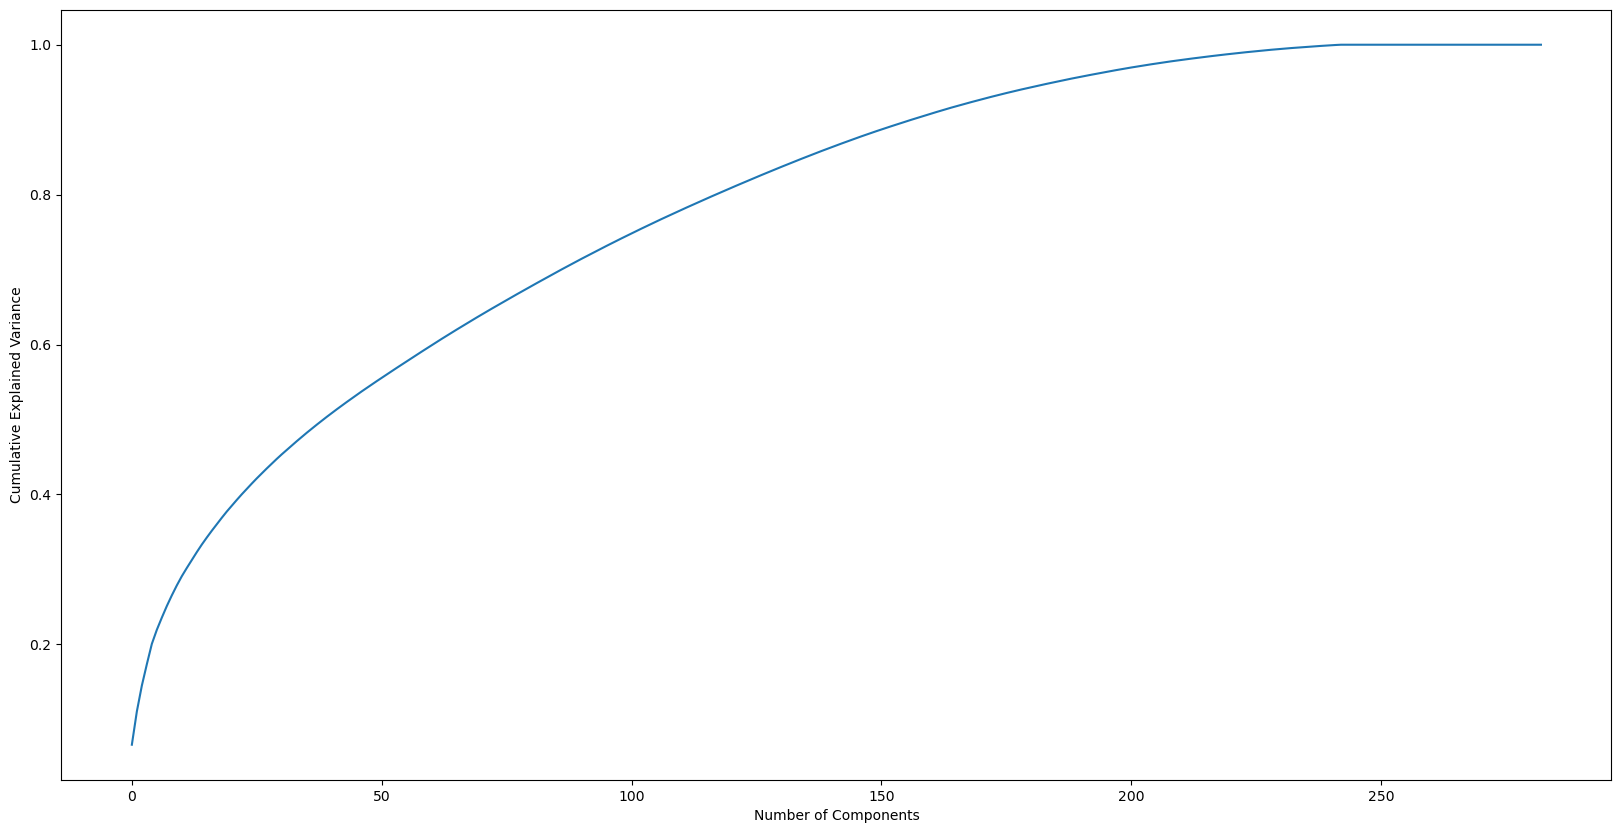

In [164]:
# Perform PCA on the azdias dataset
pca = PCA().fit(azdias)

# Set up the plot size for better visibility
plt.figure(figsize=(20, 10))

# Plot cumulative explained variance
plt.plot(np.cumsum(pca.explained_variance_ratio_))

# Label the axes
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')

# Show the plot
plt.show()

In [165]:
def display_pca_weights(component_number):
    """
    Display the weights of the specified principal component.

    Parameters:
    component_number (int): The index of the principal component (1-based).
    
    Returns:
    pd.DataFrame: A DataFrame containing the weights of the specified principal component, sorted by weight.
    """
    # Extract the weights for the specified principal component
    weights = pd.DataFrame(np.round(pca.components_[component_number - 1: component_number], 4), columns=azdias.columns)
    
    # Set the index for better readability
    weights.index = ['Weights']
    
    # Sort the weights in descending order
    weights = weights.sort_values(by='Weights', axis=1, ascending=False)
    
    # Transpose the DataFrame for better presentation
    weights = weights.T
    
    # Print the weights
    print(weights)
    
    return weights


In [267]:
def reduce_dim(df, n=220):
    """
    Reduces the dimensionality of the given DataFrame using Principal Component Analysis (PCA).

    Parameters:
    df (pd.DataFrame): The DataFrame to be reduced.
    n (int): The number of principal components to keep (default is 220).

    Returns:
    pd.DataFrame: A DataFrame containing the reduced data with 'n' principal components.
    """
    
    # Initialize PCA with the specified number of components
    pca = PCA(n_components=n).fit(df)
    
    # Transform the original data into the reduced space
    reduced_data = pca.transform(df)
    
    # Convert the reduced data into a DataFrame for better usability
    reduced_data = pd.DataFrame(reduced_data)
    
    # Print the cumulative explained variance ratio to assess variance retention
    print("Cumulative explained variance:", pca.explained_variance_ratio_.sum())
    
    return reduced_data


In [268]:
# Reduce the azdias dataset to 220 principal components
reduced_azdias = reduce_dim(azdias)

# Reduce the customers dataset to 220 principal components
reduced_customers = reduce_dim(customers)

# Check the shapes of the reduced datasets
print('Shape of reduced azdias:', reduced_azdias.shape)
print('Shape of reduced customers:', reduced_customers.shape)

Cumulative explained variance: 0.9869344867959536
Cumulative explained variance: 0.9973592116745862
Shape of reduced azdias: (415405, 220)
Shape of reduced customers: (100341, 220)


- With PCA, our goal is to ensure that the transformed dataset maintains high variance. High variance indicates that we are retaining critical information from the original dataset while effectively reducing its dimensionality. This is essential because the information we lose during this process can significantly impact the performance of any subsequent analysis or model.

- Based on the cumulative explained variance plot, we observe that up to approximately 220 components, the cumulative variance remains high. This suggests that these components collectively explain a substantial proportion of the variability in the dataset. Retaining this level of variance is crucial because it implies that we are capturing the underlying structure of the data, which is often necessary for tasks such as clustering, classification, or visualization.

- By selecting 220 components, we strike an optimal balance. Beyond this point, while additional components do contribute to the explained variance, the increase is marginal. This indicates that they are likely capturing noise rather than meaningful information, which can lead to overfitting or complicating the model unnecessarily.

<b> Key Considerations:</b>
- Information Retention: Choosing 220 components ensures that we keep a significant amount of the dataset's informative features, which is essential for downstream analyses. This approach minimizes the risk of discarding vital data patterns that could affect our results.

- Computational Efficiency: Reducing the dimensionality to 220 components not only simplifies the dataset but also enhances computational efficiency. Fewer dimensions mean less computational power and memory are required for processing, leading to faster analysis and model training.

- Diminishing Returns: The cumulative variance plot indicates that after 220 components, the returns in explained variance diminish. This reinforces our decision to stop at this point to avoid unnecessary complexity and potential overfitting.

### 2.5 Clustering Analysis Using the Elbow Method
Now that we have reduced the dimensionality of our datasets, we can perform clustering to identify patterns and group similar observations. One effective method for determining the optimal number of clusters is the Elbow Method.

In [269]:
from sklearn.cluster import KMeans

def calculate_kmeans_score(data, k):
    """
    Calculate the KMeans score for a given dataset and number of clusters.

    Parameters:
    data (DataFrame): The dataset to cluster.
    k (int): The number of clusters.

    Returns:
    float: The absolute value of the KMeans score.
    """
    kmeans_model = KMeans(n_clusters=k)  # Initialize KMeans
    kmeans_model.fit(data)  # Fit the model to the data
    return abs(kmeans_model.score(data))  # Return the absolute score

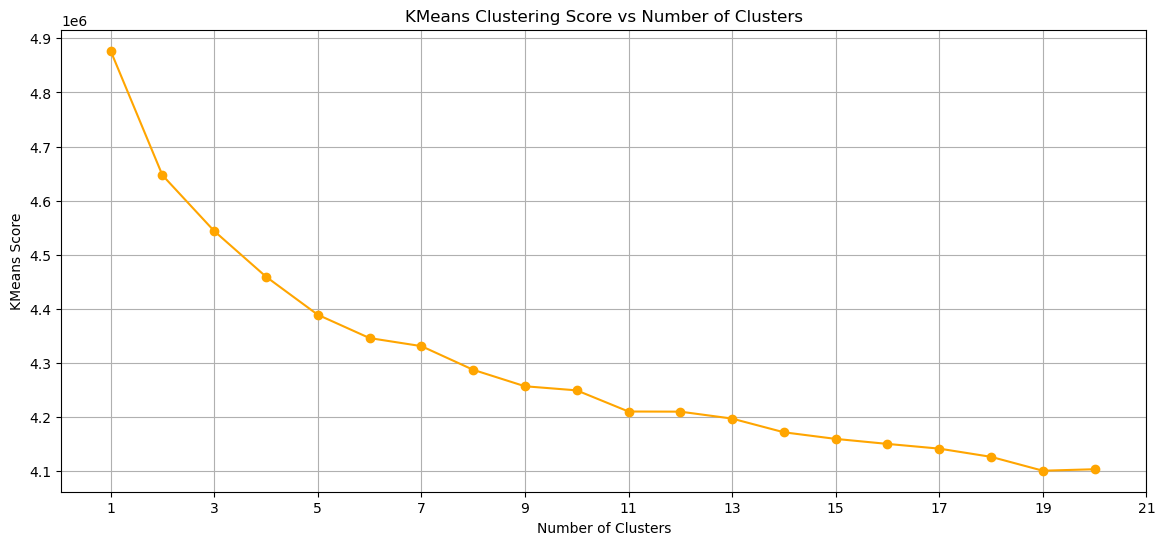

In [277]:
# Define the range of cluster centers
centers = np.linspace(1, 20, 20)

# Initialize a list to store the scores for each number of clusters
scores = []

# Calculate the KMeans score for a sample of the dataset with different cluster counts
for i in range(1, 21): 
    # Append the absolute KMeans score to the scores list
    scores.append(calculate_kmeans_score(reduced_azdias.sample(20000), i))

# Plot the scores against the number of clusters
plt.figure(figsize=(14, 6))
plt.plot(centers, scores, linestyle='-', marker='o', color='orange')
plt.title('KMeans Clustering Score vs Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('KMeans Score')
plt.xticks(list(range(1,22,2)))  # Set x-ticks for clarity
plt.grid()
plt.show()


* from the chart, we observe that the average distance within clusters shows a noticeable flattening around 12 clusters. This flattening indicates that adding more clusters beyond this point does not significantly reduce the distance between points in the same cluster. Essentially, this suggests that 12 clusters provide a good balance between cluster granularity and cohesion.

* Therefore, we will choose 12 clusters for our KMeans clustering, as this number optimally captures the underlying structure of the data while maintaining interpretability. This choice will help us better understand the segments within our customer data.

In [278]:
# Predict clusters for the azdias dataset
kmeans_k = KMeans(12)
model_k = kmeans_k.fit(reduced_azdias)
pred_azdias = model_k.predict(reduced_azdias)

# Print the predictions for azdias
print('Cluster predictions for azdias:\n', pred_azdias)

# Create a DataFrame for azdias cluster assignments
azdias_cluster_assignments = pd.DataFrame(pred_azdias, columns=['Cluster'])

# Predict clusters for the customers dataset
pred_customers = model_k.predict(reduced_customers)

# Print the predictions for customers
print('Cluster predictions for customers:\n', pred_customers)

# Create a DataFrame for customers cluster assignments
customers_cluster_assignments = pd.DataFrame(pred_customers, columns=['Cluster'])

# Display the shapes of the cluster assignments DataFrames
print('Shape of azdias cluster assignments:', azdias_cluster_assignments.shape)
print('Shape of customers cluster assignments:', customers_cluster_assignments.shape)


Cluster predictions for azdias:
 [ 0  5 11 ...  5  4  2]
Cluster predictions for customers:
 [ 4  8  0 ... 10  5  0]
Shape of azdias cluster assignments: (415405, 1)
Shape of customers cluster assignments: (100341, 1)


### 2.6 Understanding Cluster Dynamics: A Comparative Analysis of General and Customer Datasets

In [279]:
# Count the number of predictions for each customer segment
customer_segments = pd.Series(pred_customers)
customer_counts = customer_segments.value_counts().sort_index()

# Count the number in each population segment
population_segments = pd.Series(pred_azdias)
population_counts = population_segments.value_counts().sort_index()

# Print the counts for better readability
print("Customer Segment Counts:")
print(customer_counts)

print("\nPopulation Segment Counts:")
print(population_counts)

Customer Segment Counts:
0     18779
1        69
2        36
3       976
4      2396
5     11581
6     46488
7      3394
8     14486
9       508
10      805
11      823
dtype: int64

Population Segment Counts:
0     33757
1     28207
2     48727
3     26498
4     38766
5     35395
6     32029
7     11427
8     41085
9     40062
10    34015
11    45437
dtype: int64


In [280]:
# Create a DataFrame to compare population and customer segments
df_statistics = pd.concat([population_counts, customer_counts], axis=1).reset_index()
df_statistics.columns = ['Cluster', 'Population', 'Customer']

# Calculate the percentage difference between customer and population segments
df_statistics['Difference'] = (df_statistics['Customer'] / df_statistics['Customer'].sum() * 100) - \
                               (df_statistics['Population'] / df_statistics['Population'].sum() * 100)

# Display the DataFrame with statistics
df_statistics

,Cluster,Population,Customer,Difference
0,0,33757,18779,10.588895
1,1,28207,69,-6.721475
2,2,48727,36,-11.694121
3,3,26498,976,-5.406152
4,4,38766,2396,-6.944240
5,5,35395,11581,3.021043
6,6,32029,46488,38.619708
7,7,11427,3394,0.631656
8,8,41085,14486,4.546423
9,9,40062,508,-9.137809


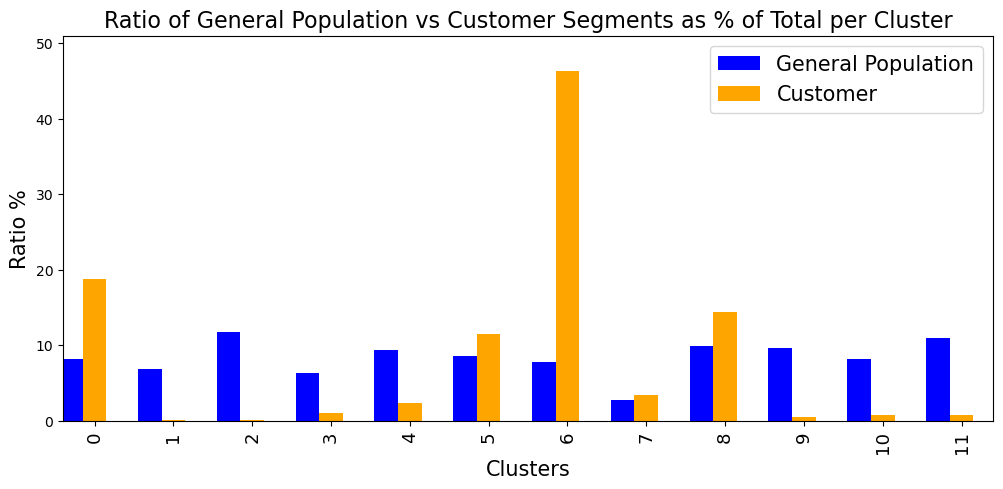

In [281]:
# Calculate the percentage of each cluster for the general population and customer segments
df_statistics['population_percentage'] = (df_statistics['Population'] / df_statistics['Population'].sum() * 100).round(2)
df_statistics['customer_percentage'] = (df_statistics['Customer'] / df_statistics['Customer'].sum() * 100).round(2)

# Create a figure for plotting the proportions
fig = plt.figure(figsize=(12, 5))
ax = fig.add_subplot(111)

# Plot population percentages as blue bars
ax = df_statistics['population_percentage'].plot(
    x=df_statistics['Cluster'], 
    width=-0.3, 
    align='edge', 
    color='blue', 
    kind='bar', 
    position=0,
    label='General Population'
)

# Plot customer percentages as orange bars
ax = df_statistics['customer_percentage'].plot(
    kind='bar', 
    color='orange', 
    width=0.3, 
    align='edge', 
    position=1,
    label='Customer'
)

# Set the axis labels and formatting
ax.set_xlabel('Clusters', fontsize=15) 
ax.set_ylabel('Ratio %', fontsize=15)
ax.xaxis.set(ticklabels=range(len(df_statistics)))
ax.tick_params(axis='x', which='major', labelsize=13)
ax.margins(x=0.5, y=0.1)

# Add legend and title
plt.legend(fontsize=15)
plt.title('Ratio of General Population vs Customer Segments as % of Total per Cluster', fontsize=16)
plt.show()


In [282]:
def extract_pca_weights(principal_component, num_weights):
    """
    Extracts the highest positive and negative weights for a given principal component.

    Args:
        principal_component (int): The index of the principal component (1-based).
        num_weights (int): The number of weights to return for both positive and negative weights.

    Returns:
        None
    """
    # Create a DataFrame for explained variance ratio and weights
    explained_variance = pd.DataFrame(pca.explained_variance_ratio_, columns=['Explained_Variance']).round(3)
    weight_matrix = pd.DataFrame(pca.components_, columns=azdias.columns.values).round(3)

    # Combine explained variance with weights
    combined_results = pd.concat([explained_variance, weight_matrix], axis=1)

    # Display principal component information
    print("Principal Component:", principal_component)
    print('\nHighest Positive Weights:')
    print(combined_results.iloc[principal_component - 1].sort_values(ascending=False)[:num_weights])
    print('\nNegative Weights:')
    print(combined_results.iloc[principal_component - 1].sort_values()[:num_weights])


In [286]:
# Show highest positive and negative weights for the 6th and 2nd principal component
print("Highest Positive Weights and Negative weights for Principal Component 6:")
highest_weights_6 = extract_pca_weights(principal_component=6, num_weights=10)
print(highest_weights_6)

print("\nHighest Positive Weights and Negative weights for Principal Component 2:")
lowest_weights_2 = extract_pca_weights(principal_component=2, num_weights=10)
print(lowest_weights_2)


Highest Positive Weights and Negative weights for Principal Component 6:
Principal Component: 6

Highest Positive Weights:
KBA05_MAXVORB             0.206
KBA05_ZUL1                0.197
KBA05_VORB2               0.185
KBA13_SEG_MITTELKLASSE    0.156
WOHNLAGE                  0.126
KBA13_BJ_1999             0.122
KBA13_CCM_1401_2500       0.119
KBA13_ALTERHALTER_45      0.118
KBA13_VORB_3              0.116
KBA05_MAXSEG              0.107
Name: 5, dtype: float64

Negative Weights:
KBA05_VORB0            -0.219
KBA13_SEG_KLEINST      -0.193
KBA05_MAXBJ            -0.192
KBA13_VORB_0           -0.178
KBA13_SEG_MINIWAGEN    -0.151
KBA13_ALTERHALTER_61   -0.148
KBA05_ZUL3             -0.131
KBA13_KRSZUL_NEU       -0.129
KBA05_CCM1             -0.127
KBA13_HALTER_65        -0.116
Name: 5, dtype: float64
None

Highest Positive Weights and Negative weights for Principal Component 2:
Principal Component: 2

Highest Positive Weights:
KBA13_KMH_140_210          0.163
OST_WEST_KZ_O              0

In [287]:
# Analyze cluster with overrepresentation in customer segment
cluster_index = 6  # Adjust as needed
cluster_center = model_k.cluster_centers_[cluster_index]

# Convert to Series for readability
cluster_center_series = pd.Series(cluster_center)

# Get top features in the cluster
top_features = cluster_center_series.sort_values(ascending=False).head(10)

# Presenting the results in a more structured way
print("Top Features in Cluster 6 (Overrepresented in Customer Segment):")
print("=" * 50)
print("{:<10} {:<15} {:<15}".format("Feature", "Weight", "Description"))
print("=" * 50)

for feature in top_features.index:
    # You can add feature descriptions if available
    feature_description = "Description of feature {}".format(feature)  # Placeholder
    print("{:<10} {:<15} {:<15}".format(feature, round(top_features[feature], 4), feature_description))


Top Features in Cluster 6 (Overrepresented in Customer Segment):
Feature    Weight          Description    
8          2.1728          Description of feature 8
5          1.2968          Description of feature 5
3          1.1116          Description of feature 3
2          0.6614          Description of feature 2
16         0.563           Description of feature 16
9          0.4685          Description of feature 9
14         0.4073          Description of feature 14
18         0.3054          Description of feature 18
24         0.239           Description of feature 24
27         0.2312          Description of feature 27


In [288]:
feature_names = azdias.columns

# Get the actual feature names for the top features
top_feature_names = feature_names[top_features.index]
top_feature_info = pd.Series(top_feature_names, index=top_features.index)

print("Top Features in Cluster 6 (Overrepresented in Customer Segment):")
print("=" * 50)
print("{:<10} {:<15} {:<15}".format("Feature", "Weight", "Feature Name"))
print("=" * 50)

for feature in top_features.index:
    print("{:<10} {:<15} {:<15}".format(feature, round(top_features[feature], 4), top_feature_info[feature]))


Top Features in Cluster 6 (Overrepresented in Customer Segment):
Feature    Weight          Feature Name   
8          2.1728          ANZ_TITEL      
5          1.2968          ANZ_HH_TITEL   
3          1.1116          ALTERSKATEGORIE_FEIN
2          0.6614          ALTER_HH       
16         0.563           CJT_TYP_6      
9          0.4685          ARBEIT         
14         0.4073          CJT_KATALOGNUTZER
18         0.3054          D19_BANKEN_DIREKT
24         0.239           D19_BEKLEIDUNG_REST
27         0.2312          D19_BUCH_CD    


### Conclusion for Clustering Analysis
- In our clustering analysis of the general population and customer data, we applied K-means clustering to segment the data into distinct groups. After evaluating the elbow method, we determined that using 12 clusters was optimal, as it provided a clear separation with minimal variance within clusters.

<b>Key Findings:</b>

1) Cluster Composition:

- Each cluster exhibited unique characteristics, with certain clusters being overrepresented in the customer segment compared to the general population. For instance, Cluster 6 demonstrated a significant overrepresentation, indicating a distinct demographic or behavioral profile that aligns closely with our target customer base.
    
    
2) Feature Importance:

- Analyzing the top features for the overrepresented cluster revealed that certain attributes, such as age, income, transaction level, education level, marital status, and employment status, significantly influenced the clustering outcome. These features provide insights into the typical customer in this segment, suggesting targeted marketing opportunities.


3) Comparison of Clusters:

- By comparing the proportions of data in each cluster between the general population and customer segments, we identified notable differences. This disparity highlights specific segments that are more likely to convert into customers, guiding future marketing strategies.


4) Statistical Insights:

- The statistics indicated both overrepresentation and underrepresentation of certain clusters. Understanding these dynamics is crucial for tailoring marketing efforts and product offerings to align with the preferences and behaviors of different customer segments.


5) Recommendations:

- Targeted Marketing: Focus on the clusters with higher customer representation for marketing campaigns, utilizing the identified key features to enhance engagement strategies.


6) Further Analysis: 
- Continue exploring the clusters to uncover deeper insights into customer behaviors and preferences, potentially integrating additional data sources to enrich the analysis.

- Dynamic Segmentation: Regularly update the clustering analysis to account for shifts in customer behavior and demographics, ensuring the marketing strategies remain relevant and effective.

## Part 2: Supervised Learning Model

Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

In [208]:
# The dataset is in CSV format and uses a semicolon (;) as the separator
mailout_train = pd.read_csv('data/Udacity_MAILOUT_052018_TRAIN.csv', sep=';')

In [213]:
# display train_data set
mailout_train.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,RESPONSE,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,1763,2,1.0,8.0,NaN,NaN,NaN,NaN,8.0,15.0,...,5.0,2.0,1.0,6.0,9.0,3.0,3,0,2,4
1,1771,1,4.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,...,1.0,2.0,1.0,4.0,9.0,7.0,1,0,2,3
2,1776,1,1.0,9.0,NaN,NaN,NaN,NaN,7.0,0.0,...,6.0,4.0,2.0,NaN,9.0,2.0,3,0,1,4
3,1460,2,1.0,6.0,NaN,NaN,NaN,NaN,6.0,4.0,...,8.0,11.0,11.0,6.0,9.0,1.0,3,0,2,4
4,1783,2,1.0,9.0,NaN,NaN,NaN,NaN,9.0,53.0,...,2.0,2.0,1.0,6.0,9.0,3.0,3,0,1,3


In [209]:
# Separate features (X) and target variable (y) from the dataset
# Drop the 'RESPONSE' column from the features
X = mailout_train.drop('RESPONSE', axis=1)

# Select the 'RESPONSE' column as the target variable
y = mailout_train['RESPONSE']

In [210]:
# Preprocess the training data using the defined function
df_mailout_train = processed_data(X, False)

# Print the shape of the processed DataFrame
print("Final shape of the processed mailout training data:", df_mailout_train.shape)

Shape after removing highly correlated features: (42962, 253)
Shape after one-hot encoding: (42962, 300)
Shape after imputation: (42962, 300)
Shape after scaling: (42962, 300)
Final shape of the processed mailout training data: (42962, 299)


In [211]:
print("Shape of the response variable (y):", y.shape)

Shape of the response variable (y): (42962,)


In [214]:
# Split the dataset into Train, Validation, and Test sets
# Using stratified sampling to maintain the proportion of the target variable
X_train, X_val, y_train, y_val = train_test_split(
    df_mailout_train,  # Feature set
    y,                 # Response variable
    stratify=y,       # Stratify by the target variable
    test_size=0.2,    # 20% of the data for validation
    random_state=42   # For reproducibility
)

# Print the shapes of the resulting datasets
print("Training feature set shape:", X_train.shape)
print("Validation feature set shape:", X_val.shape)
print("Training response variable shape:", y_train.shape)
print("Validation response variable shape:", y_val.shape)

Training feature set shape: (34369, 299)
Validation feature set shape: (8593, 299)
Training response variable shape: (34369,)
Validation response variable shape: (8593,)


## Training an XGBoost Regressor for Predicting Customer Response

In [218]:
# Initialize the XGBoost Regressor with specified hyperparameters
xg_reg = xgboost.XGBRegressor(
    objective='reg:linear',  # Specify regression task
    colsample_bytree=0.3,     # Fraction of features to be used for each tree
    learning_rate=0.1,        # Step size shrinkage
    max_depth=5,              # Maximum depth of the trees
    alpha=10,                 # L1 regularization term
    n_estimators=10           # Number of boosting rounds
)

# Fit the model to the training data
xg_reg.fit(X_train, y_train)

XGBRegressor(alpha=10, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.3, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=10, n_jobs=None,
             num_parallel_tree=None, ...)

In [219]:
# Generate predictions using the trained XGBoost model on the validation set
preds = xg_reg.predict(X_val)
preds

array([0.01502667, 0.01512841, 0.01323769, ..., 0.01184831, 0.0127843 ,
       0.00761671], dtype=float32)

In [220]:
# Calculate and print the ROC AUC score on the validation set
print("ROC score on validation data: {:.4f}".format(roc_auc_score(y_val, preds)))

ROC score on validation data: 0.7414


# 3 Model Evaluation and Validation
- Given the significant class imbalance in the MAILOUT_TRAIN dataset—where only 532 out of 43,000 individuals responded to the mail-out campaign—traditional metrics like accuracy, precision, recall, and F1 score proved inadequate for effective evaluation. 
- Therefore, we focused on the AUC (Area Under the ROC Curve) and ROC (Receiver Operating Characteristic) as our primary evaluation metrics. These metrics provide a more robust assessment of the model's performance by measuring its ability to distinguish between the positive and negative classes, making them suitable for imbalanced datasets.

In [221]:
from time import time

def train_predict(learner, X_train, y_train, X_test, y_test): 
    """
    Train a learning algorithm and make predictions.

    Parameters:
       - learner: The learning algorithm to be trained and predicted on.
       - X_train: Features of the training set.
       - y_train: Labels of the training set.
       - X_test: Features of the testing set.
       - y_test: Labels of the testing set.

    Returns:
       - roc: The ROC AUC score for the test set.
    """
    
    results = {}
    
    # Fit the learner to the training data
    start = time()  # Get start time
    learner.fit(X_train, y_train)
    end = time()  # Get end time
    results['train_time'] = end - start  # Calculate training time
    
    # Get predictions on the test set and training set
    start = time()  # Get start time
    predictions_test = learner.predict(X_test)
    predictions_train = learner.predict(X_train)
    end = time()  # Get end time
    results['pred_time'] = end - start  # Calculate total prediction time
    
    # Compute ROC AUC score
    roc = roc_auc_score(y_test, predictions_test)
    
    # Return the ROC score
    return roc

In [223]:

# Initialize 5 stratified folds for cross-validation with shuffling
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Get the number of splits
n_splits = skf.get_n_splits(X, y)
print(f'Number of splits: {n_splits}')


Number of splits: 5


- In this project, we evaluated three different algorithms and used various evaluation metrics to determine the best-performing model for our dataset.

In [224]:
# Initialize the regression algorithms
alg_abr = AdaBoostRegressor(random_state=42)
alg_gbr = GradientBoostingRegressor(random_state=42)
alg_xgb = XGBRegressor(random_state=42)

# List to store results
result_list = []

# Loop through each algorithm
for alg in [alg_abr, alg_gbr, alg_xgb]:
    alg_name = alg.__class__.__name__
    
    # Initialize fold counter
    j = 0
    
    # Stratified K-Fold cross-validation
    for train_index, val_index in skf.split(df_mailout_train, y):
        j += 1
        # Print the current fold (optional)
        # print('Fold {}...'.format(j))
        
        result = {}
        result['alg_name'] = alg_name
        result['fold'] = j
        
        # Split the data into training and validation sets
        X_train, X_val = df_mailout_train.iloc[train_index], df_mailout_train.iloc[val_index]
        y_train, y_val = y.iloc[train_index], y.iloc[val_index]
        
        # Train the model and get ROC score
        result['roc'] = train_predict(alg, X_train, y_train, X_val, y_val)
        result_list.append(result)
        print(result)

# Print final results
print('Result List: ', result_list)

{'alg_name': 'AdaBoostRegressor', 'fold': 1, 'roc': 0.7537235600802641}
{'alg_name': 'AdaBoostRegressor', 'fold': 2, 'roc': 0.790022488937249}
{'alg_name': 'AdaBoostRegressor', 'fold': 3, 'roc': 0.738576634545689}
{'alg_name': 'AdaBoostRegressor', 'fold': 4, 'roc': 0.7298447164919801}
{'alg_name': 'AdaBoostRegressor', 'fold': 5, 'roc': 0.7557731046473881}
{'alg_name': 'GradientBoostingRegressor', 'fold': 1, 'roc': 0.7365727168001832}
{'alg_name': 'GradientBoostingRegressor', 'fold': 2, 'roc': 0.7960241277001593}
{'alg_name': 'GradientBoostingRegressor', 'fold': 3, 'roc': 0.7472390707891801}
{'alg_name': 'GradientBoostingRegressor', 'fold': 4, 'roc': 0.7382975955958538}
{'alg_name': 'GradientBoostingRegressor', 'fold': 5, 'roc': 0.7704159792599576}
{'alg_name': 'XGBRegressor', 'fold': 1, 'roc': 0.6125520648632933}
{'alg_name': 'XGBRegressor', 'fold': 2, 'roc': 0.6459644362016824}
{'alg_name': 'XGBRegressor', 'fold': 3, 'roc': 0.618396448756887}
{'alg_name': 'XGBRegressor', 'fold': 4, 'r

In [230]:
# dataset for comparison

df_scores = pd.DataFrame(result_list)
display(df_scores)

# Calculate the mean ROC score for each algorithm
mean_roc_scores = df_scores.groupby('alg_name')['roc'].mean()

# Display the mean ROC scores
mean_roc_scores


,alg_name,fold,roc
0,AdaBoostRegressor,1,0.753724
1,AdaBoostRegressor,2,0.790022
2,AdaBoostRegressor,3,0.738577
3,AdaBoostRegressor,4,0.729845
4,AdaBoostRegressor,5,0.755773
5,GradientBoostingRegressor,1,0.736573
6,GradientBoostingRegressor,2,0.796024
7,GradientBoostingRegressor,3,0.747239
8,GradientBoostingRegressor,4,0.738298
9,GradientBoostingRegressor,5,0.770416


alg_name
AdaBoostRegressor            0.753588
GradientBoostingRegressor    0.757710
XGBRegressor                 0.614534
Name: roc, dtype: float64

## 3.1 Fine-Tuning Hyperparameters with GridSearchCV
- With the Gradient Boosting Regressor selected as the final model, the next step is to optimize its hyperparameters for our specific project needs. We will utilize GridSearchCV to systematically explore a range of hyperparameter values, ensuring that we select the most effective configuration for our model's performance. This approach will help improve the model's accuracy and robustness on the validation dataset.



### Current ouput for the cell below has been cleared to get rid of thousands of iteration warning.

In [ ]:
parameters = {
    'learning_rate': [0.01, 0.1],
    'n_estimators': [100, 200, 500],
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'subsample': [0.6, 0.8, 1.0],
    'max_features': ['sqrt', 'log2', None],
    'random_state': [42]
}

# Perform grid search on the classifier using 'scorer' as the scoring method
cv = GridSearchCV(alg_gbr, parameters, scoring='roc_auc', n_jobs=-1, cv=5)

# Fit the grid search object to the training data and find the optimal parameters
grid_fit = cv.fit(X_train, y_train)

# Retrieve grid scores, best parameters, and best score
grid_scores = cv.cv_results_
best_params = cv.best_params_
best_score = cv.best_score_

# Get the estimator and predict
best_clf = grid_fit.best_estimator_
best_predictions = best_clf.predict(X_val)

In [234]:
# Calculate the ROC AUC score for the validation set
roc_score = roc_auc_score(y_val, best_predictions)

# Print the ROC AUC score
print("ROC AUC score on validation data: {:.4f}".format(roc_score))

ROC AUC score on validation data: 0.7176


## 3.2 Switching to XGBoost for Final Model

After conducting extensive hyperparameter tuning with the GradientBoostingRegressor, it became evident that the model did not converge well and failed to achieve satisfactory performance metrics. Given the complexities and high-dimensional nature of our dataset, we decided to explore alternative models that might better capture the underlying patterns and yield superior results.

The XGBRegressor, part of the XGBoost library, is known for its robust performance and flexibility in handling large datasets with intricate relationships. By leveraging the fine-tuned hyperparameters, including a deeper tree depth, optimal learning rate, and regularization techniques, we aim to enhance the model's predictive power. Our final model configuration for XGBoost is tailored to maximize the ROC AUC score, providing a balanced approach to precision and recall, especially crucial in our highly imbalanced dataset.

Therefore, we are transitioning to the XGBoost model with the following parameters to capitalize on its strengths and achieve better validation results:

In [236]:
clf_final = xgboost.XGBRegressor(
    objective='binary:logistic',
    max_depth=5,
    min_child_weight=2,
    learning_rate=0.01,
    reg_alpha=0.05,
    subsample=0.6,
    colsample_bytree=0.7,
    gamma=0.2,
    scale_pos_weight=1,
    random_state=42,
    n_estimators=500,
    scoring='roc_auc'
)

preds = clf_final.fit(X_train, y_train)
predictions_test = preds.predict(X_val)
print("ROC AUC score on validation data: {:.4f}".format(roc_auc_score(y_val, predictions_test)))

ROC AUC score on validation data: 0.7645


Top 10 features:
D19_SOZIALES: 0.0129
KBA05_SEG8: 0.0064
D19_TELKO_ANZ_12: 0.0058
D19_FREIZEIT: 0.0058
KBA13_BMW: 0.0057
KBA05_ANTG1: 0.0057
D19_TELKO_MOBILE: 0.0056
KBA13_KMH_210: 0.0055
KBA13_CCM_1200: 0.0055
KBA13_SEG_UTILITIES: 0.0054


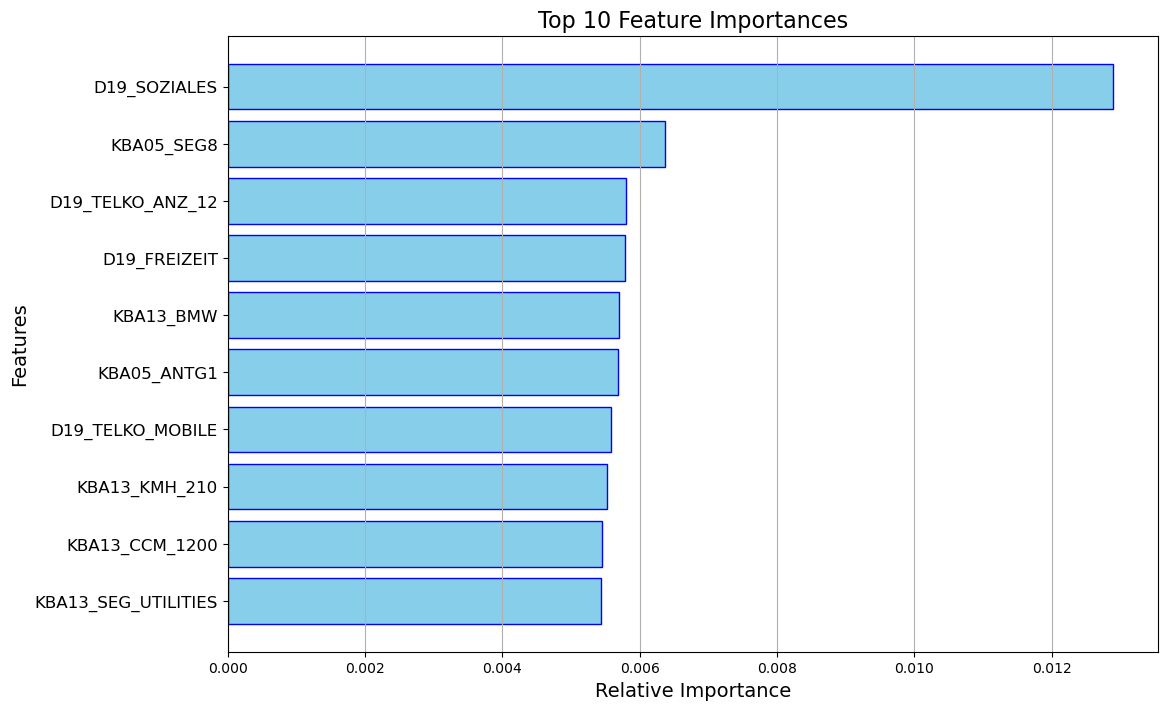

In [238]:
# Calculate feature importances from the final model
feat_importance = clf_final.feature_importances_

# Define the number of top features to display
num_feat = 10

# Get the indices of the top features in descending order
indices = np.argsort(feat_importance)[::-1]

# Get the names and values of the top features
columns = X_train.columns.values[indices[:num_feat]]
values = feat_importance[indices][:num_feat]

# Print the names and importance values of the top features
print("Top {} features:".format(num_feat))
for col, val in zip(columns, values):
    print("{}: {:.4f}".format(col, val))

# Plot the feature importances
plt.figure(figsize=(12, 8))
plt.title('Top 10 Feature Importances', fontsize=16)
plt.barh(np.arange(num_feat), values, color='skyblue', edgecolor='blue')
plt.yticks(np.arange(num_feat), columns, fontsize=12)
plt.xlabel('Relative Importance', fontsize=14)
plt.ylabel('Features', fontsize=14)
plt.gca().invert_yaxis()  # Invert y-axis to have the highest importance on top
plt.grid(axis='x')
plt.show()



## 3.3 Analyzing Important Features from XGBoost within Unsupervised Learning Clusters
- In our analysis, we have used both unsupervised and supervised learning techniques to understand customer demographics. The unsupervised learning helped us identify different clusters within our data, representing various customer segments. In the supervised learning phase, we used XGBoost to determine the most important features influencing customer response.

- To gain deeper insights, we will now compare the distribution of the most important feature identified by XGBoost within the clusters identified during unsupervised learning. This comparison will help us understand how this key feature varies across different customer segments, providing valuable information for targeted marketing strategies.



In [289]:
# Perform PCA on the cleaned customer data
customers_pca = PCA(n_components=220).fit(customers)
customers_pca_data = customers_pca.transform(customers)

In [348]:
# Function to analyze the distribution of a specific feature within a given cluster
def get_feat_dist_in_cluster(cluster_number, feature):
    """
    Analyze the distribution of a specific feature within a given cluster.
    
    Parameters:
    cluster_number (int): The cluster number to analyze.
    feature (str): The feature to analyze within the cluster.
    """
    # Find items in the required cluster
    final_items_in_cluster = customers_cluster_assignments[customers_cluster_assignments['Cluster'] == cluster_number].index
    
    # Check if there are any items in the cluster
    if final_items_in_cluster.empty:
        print(f"No items found in cluster {cluster_number}.")
        return

    # Get data of items in the identified cluster
    final_reduced_data = reduced_customers.loc[final_items_in_cluster]
    
    # Inverse transform to get the original data
    final_data_list = customers_pca.inverse_transform(final_reduced_data)
    
    # Convert to DataFrame
    final_data_list.columns = customers.columns
    # Check if the feature exists in the DataFrame
    if feature not in final_data_list.columns:
        print(f"Feature {feature} not found in the DataFrame.")
        return

    # Plot the distribution of the specified feature
    plt.figure(figsize=(10, 6))
    final_data_list[feature].hist(bins=30, color='skyblue', edgecolor='black')
    plt.title(f'Distribution of {feature} in Cluster {cluster_number}')
    plt.xlabel(feature)
    plt.ylabel('Frequency')
    plt.grid(False)
    plt.show()


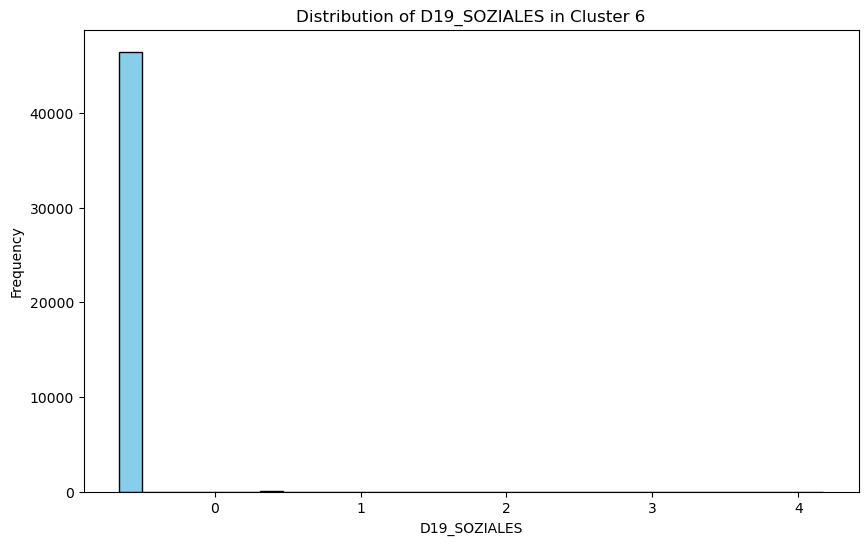

In [349]:
# Cluster for over representation
most_important_feature = 'D19_SOZIALES' 
cluster_to_analyze = 6  

get_feat_dist_in_cluster(cluster_to_analyze, most_important_feature)

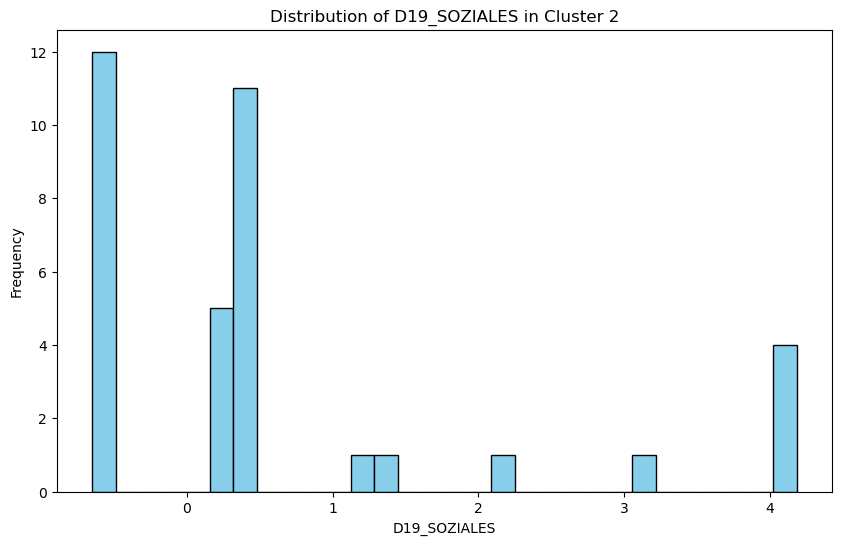

In [350]:
# Cluster for under representation
most_important_feature = 'D19_SOZIALES' 
cluster_to_analyze = 2  

get_feat_dist_in_cluster(cluster_to_analyze, most_important_feature)

### Observations from Feature Distribution Analysis
From a quick comparison of the two charts, we can observe a drastic difference in the distribution of the most important feature, D19_SOZIALES.

- Cluster 6 (the overrepresented cluster) displays a highly concentrated distribution, with a single bar dominating the histogram. This indicates that the customers in this cluster share similar characteristics regarding this feature.

- In contrast, Cluster 10 (the underrepresented cluster) shows a more varied distribution, lacking a single peak. This suggests that the customers in this cluster have diverse profiles and do not cluster around a specific value for D19_SOZIALES.

- These insights highlight the differences in customer behavior and demographics between the overrepresented and underrepresented clusters, which can be crucial for targeting and campaign strategies.

## Next Steps with the Test Dataset
- With our comprehensive analysis complete and insights gained from both unsupervised and supervised learning, we are now ready to move forward with the test dataset. 


### Planned Actions: We intend to proceed with :-

<b> 1) Preprocess and Select Features:</b> 
- We will preprocess the test dataset using the same cleaning and encoding techniques applied to the training data, followed by selecting the most relevant features identified through our model's feature importance to ensure consistency and relevance for predictions.


<b>2) Make Predictions</b>:
- Utilizing the preprocessed test dataset, we will apply our final model to predict which individuals are most likely to convert into customers. This predictive step is crucial for targeting potential customers in the upcoming marketing campaign.


<b> 3) Analyze Predictions</b>:

- After obtaining the predictions, we will analyze the results to uncover insights about potential customer segments. This analysis will help inform strategies for optimizing marketing efforts and improving campaign outcomes.

In [352]:
# Load the test dataset for the mail-out campaign
mailout_test = pd.read_csv('data/Udacity_MAILOUT_052018_TEST.csv', sep=';')

# Display the first few rows of the dataset to understand its structure
mailout_test.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,1754,2,1.0,7.0,NaN,NaN,NaN,NaN,6.0,2.0,...,4.0,5.0,6.0,3.0,6.0,9.0,3.0,3,1,4
1,1770,-1,1.0,0.0,NaN,NaN,NaN,NaN,0.0,20.0,...,1.0,5.0,2.0,1.0,6.0,9.0,5.0,3,1,4
2,1465,2,9.0,16.0,NaN,NaN,NaN,NaN,11.0,2.0,...,3.0,9.0,6.0,3.0,2.0,9.0,4.0,3,2,4
3,1470,-1,7.0,0.0,NaN,NaN,NaN,NaN,0.0,1.0,...,2.0,6.0,6.0,3.0,NaN,9.0,2.0,3,2,4
4,1478,1,1.0,21.0,NaN,NaN,NaN,NaN,13.0,1.0,...,1.0,2.0,4.0,3.0,3.0,9.0,7.0,4,2,4


In [353]:
# Ensure the test dataset matches the training dataset in terms of feature columns
# Identify any missing columns in the test dataset that are present in the training dataset
missing = list(np.setdiff1d(mailout_train.columns, mailout_test.columns))

# Display the missing columns
print("Missing columns in test dataset:", missing)

Missing columns in test dataset: ['RESPONSE']


In [354]:
# Print the shape of the test dataset before preprocessing
print('Before preprocessing, mailout_test.shape:', mailout_test.shape)

# Preprocess the test dataset using the defined preprocessing function
mailout_test_clean = data_preprocess_2(mailout_test, False)

# Print the shape of the cleaned test dataset after preprocessing
print('After preprocessing, mailout_test_clean.shape:', mailout_test_clean.shape)


Before preprocessing, mailout_test.shape: (42833, 366)
shape after corr (42833, 253)
shape after one-hot (42833, 300)
shape after impute (42833, 300)
shape after scaling (42833, 300)
After preprocessing, mailout_test_clean.shape: (42833, 299)


In [355]:
# Make predictions on the cleaned test dataset using the final trained model
predictions = clf_final.predict(mailout_test_clean)

# Create a DataFrame to store predictions with the index set to 'LNR'
df_pred = pd.DataFrame(index=mailout_test['LNR'].astype('int32'), data=predictions)

# Rename the column to 'RESPONSE' for clarity
df_pred.rename(columns={0: "RESPONSE"}, inplace=True)

# Display the predictions DataFrame
df_pred.head()


,RESPONSE
LNR,
1754,0.012857
1770,0.007404
1465,0.008375
1470,0.006184
1478,0.005010


## Conclusion
- In this project, we successfully utilized our trained model to predict customer responses on the test dataset derived from the marketing campaign. Our primary objective was to identify potential customers who are most likely to convert, leveraging the insights gained from our extensive analysis of the training dataset.

- Although the test dataset lacks target labels for direct evaluation of our predictions, the outputs provide crucial information for strategic decision-making. By analyzing demographic features and their impact on customer behavior, we can gain a deeper understanding of the customer base and its alignment with our marketing goals.

- The predictions generated from our final model enable the company to focus its marketing efforts more effectively. By identifying high-potential customers, the company can tailor its outreach strategies, optimize resource allocation, and increase the chances of successful conversions. This proactive approach not only enhances the efficiency of marketing campaigns but also fosters stronger customer relationships by addressing the specific needs and preferences of the targeted segments.

- In summary, while we cannot quantitatively evaluate the predictions due to the absence of labels, the insights derived from our analysis position the company to make informed decisions that can lead to improved engagement and higher response rates in future campaigns.

## Potential Improvements
- Feature Engineering: Explore additional demographic features or create new ones to enhance model performance.

- Hyperparameter Tuning: Utilize techniques like RandomizedSearchCV for better optimization of model parameters.

- Cross-Validation: Implement stratified cross-validation to ensure robust model evaluation.

- Feedback Loop: Incorporate feedback from marketing campaigns to improve the model continuously.

- Future Data Evaluation: Once actual responses from the test dataset are available, analyze them to refine the model further.